# 3 Features Construction

## 3.3 Raw Rolling Returns

### 3.3.1 Imports and Loads Needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import yfinance as yf

plot_args = {"figsize": (21,9),            
            "legend": True}

plt.style.use("ggplot")            

In [2]:
## Custom Made Module
from modules import performance_measures_helper as pms

In [3]:
with open("data/config/20220831_returns_scores.pkl","rb") as handle:
    data = pickle.load(handle)

baseline_daily_rets = data["raw_returns"]["daily"]

In [4]:
rsp_etf = yf.download(
    "RSP",
    start=baseline_daily_rets.index[0],
    end=baseline_daily_rets.index[-1],
)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [5]:
base_port_daily_rets = baseline_daily_rets.mean(axis=1, skipna=True)
base_port_daily_rets.shape

(4007,)

#### Checks and Preparation

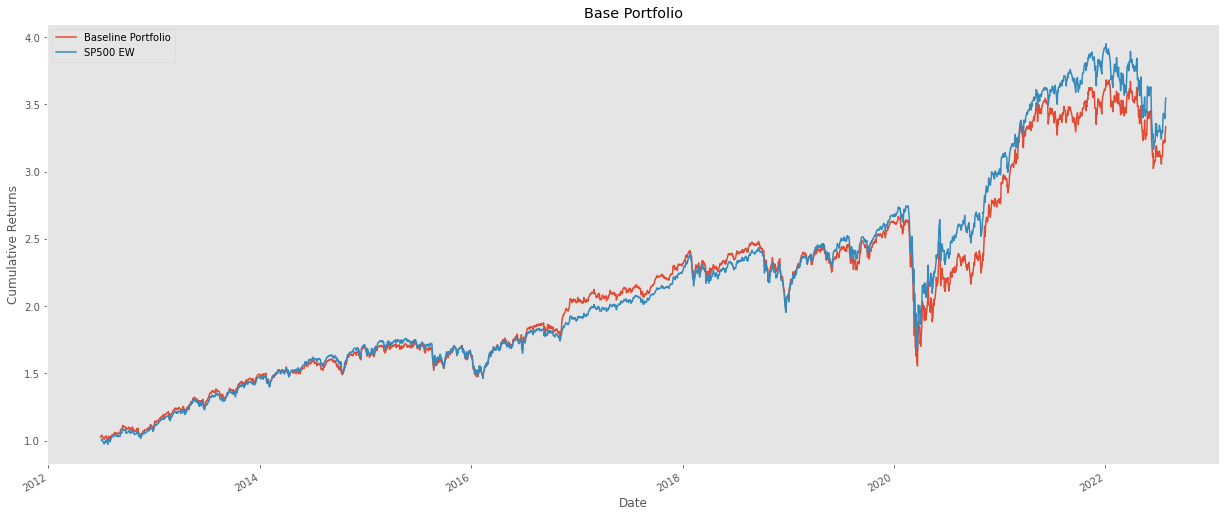

In [18]:
(1+pms.net_cumreturn(base_port_daily_rets[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT])).rename("Baseline Portfolio").plot(**plot_args)
(1+pms.net_cumreturn(rsp_etf[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT].pct_change()+0.002/252)).rename("SP500 EW").plot(**plot_args)
plt.grid()
plt.title("Base Portfolio")
plt.ylabel("Cumulative Returns");

In [7]:
daily_cumrets = pms.net_cumreturn(baseline_daily_rets)

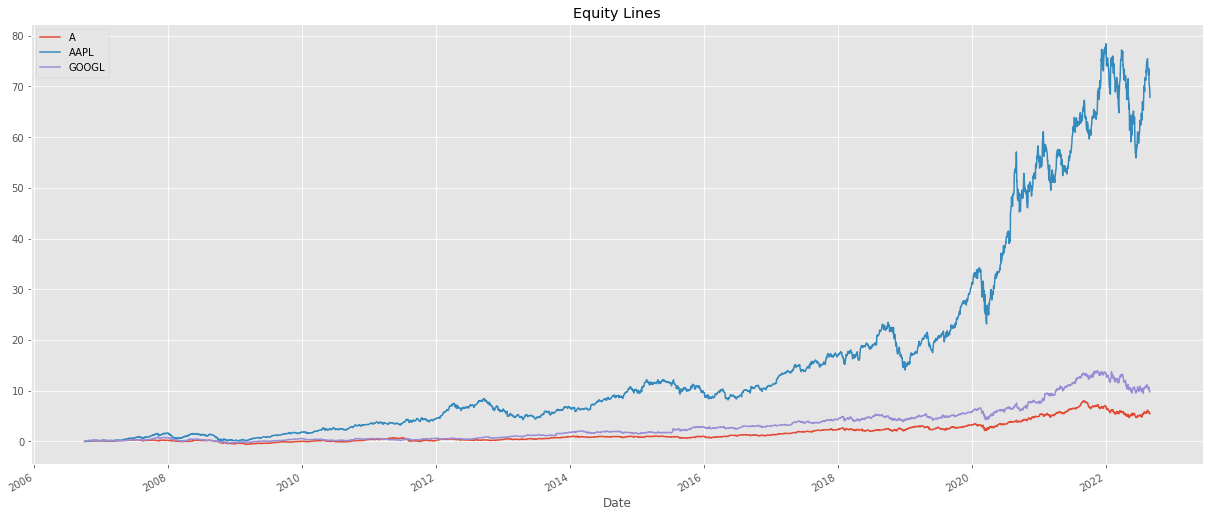

In [8]:
plt.style.use("ggplot")
daily_cumrets[["A", "AAPL", "GOOGL"]].plot(**plot_args, title="Equity Lines");
#plt.semilogy()


### 3.3.2 **Rolling Returns** Calculation and Visualizations

Cumulative Returns are normalized (adjusted) prices, so we can discuss rolling returns from now on

In [15]:
from modules.constants import START_TRAINING_DATE_CUT, END_TRAINING_DATE_CUT
print(START_TRAINING_DATE_CUT)
print(END_TRAINING_DATE_CUT)

2012-06-29
2022-07-29


In [10]:
baseline_daily_rets.columns

Index(['A', 'AAPL', 'ABC', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE',
       ...
       'NWN', 'PRGO', 'RGP', 'SBCF', 'SHBI', 'UGI', 'WAFD', 'FORR', 'FRT',
       'WABC'],
      dtype='object', length=469)

In [11]:
# First Cut
baseline_daily_rets = baseline_daily_rets[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT]

In [12]:
sp500 = pd.read_csv(
    "data/config/20220814_daily_raw_returns_merged.csv",
    index_col="Date",
    parse_dates=True
)

In [13]:
sp500 = sp500[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT]

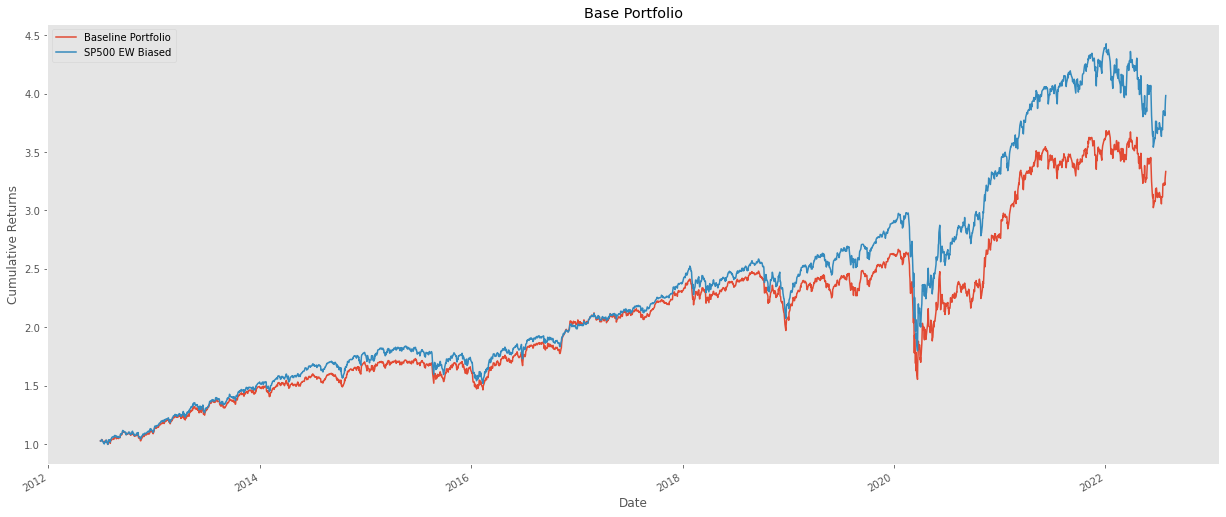

In [14]:
(1+pms.net_cumreturn(baseline_daily_rets.mean(axis=1))).rename("Baseline Portfolio").plot(**plot_args)
(1+pms.net_cumreturn(sp500.mean(axis=1,skipna=True))).rename("SP500 EW Biased").plot(**plot_args)
plt.grid()
plt.title("Base Portfolio")
plt.ylabel("Cumulative Returns");

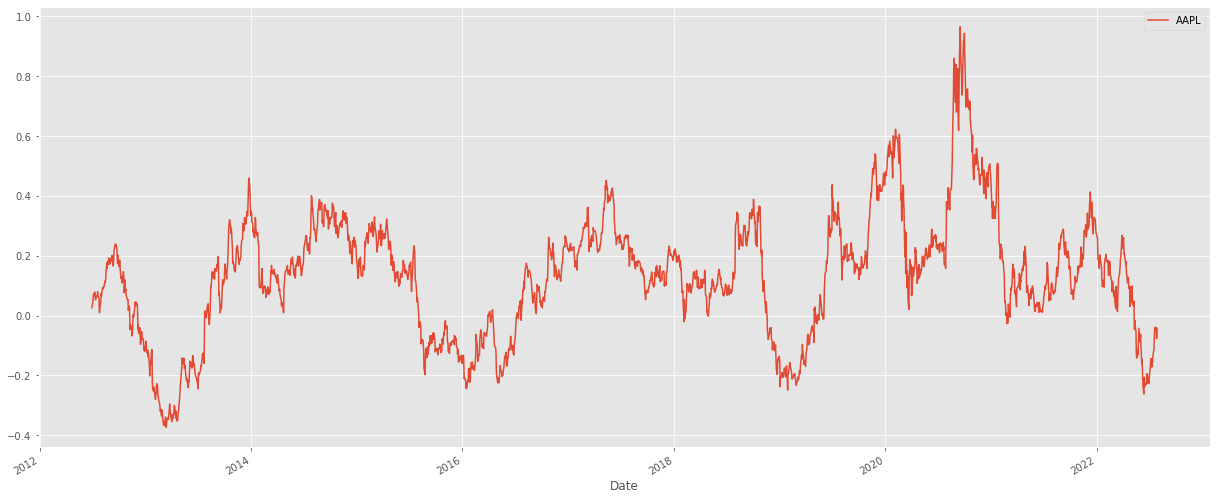

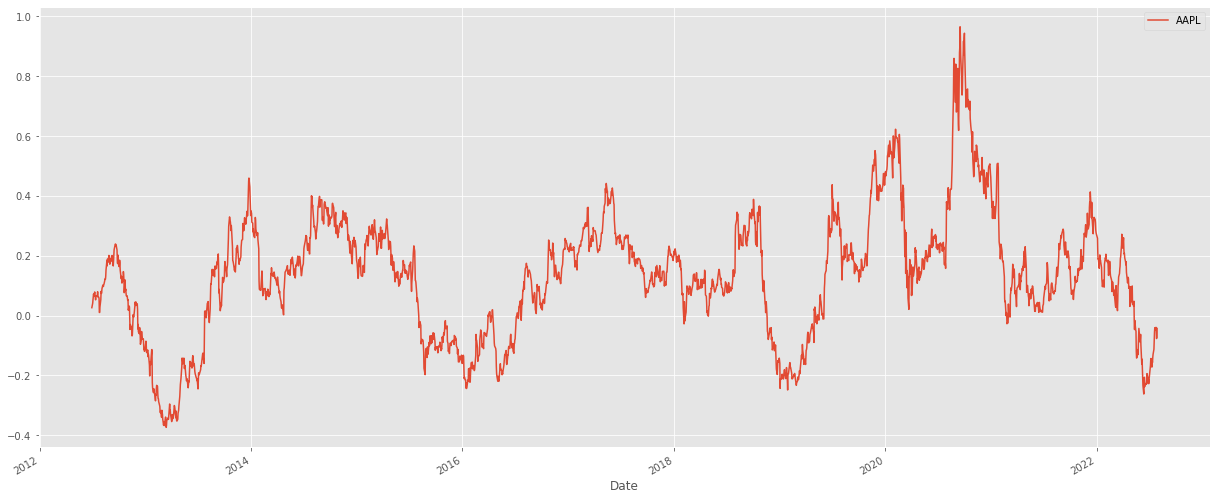

In [19]:
baseline_daily_rets[["AAPL"]].rolling(window="180D").apply(pms.multi_period_return).plot(**plot_args)
sp500[["AAPL"]].rolling(window="180D").apply(pms.multi_period_return).plot(**plot_args);

#### 3.3.2.1 Daily Sampled Rolling Returns for 3M, 6M and 12M Horizons

##### __Baseline Portfolio__

In [20]:
baseline_rolling_rets = {}
baseline_rolling_rets["raw_cumrets"] = {}
baseline_rolling_rets["raw_cumrets"]["daily"] = {}

In [21]:
wins = ["1m", "3m", "6m", "12m"]
nperiods = ["30D", "60D", "180D", "360D"]

for win, nperiod in zip(wins,nperiods):
    baseline_rolling_rets["raw_cumrets"]["daily"][win] = baseline_daily_rets.rolling(window=nperiod).apply(
        pms.multi_period_return, 
        engine="numba", 
        raw=True
    )    

In [22]:
baseline_rolling_rets["raw_cumrets"]["daily"].keys()

dict_keys(['1m', '3m', '6m', '12m'])

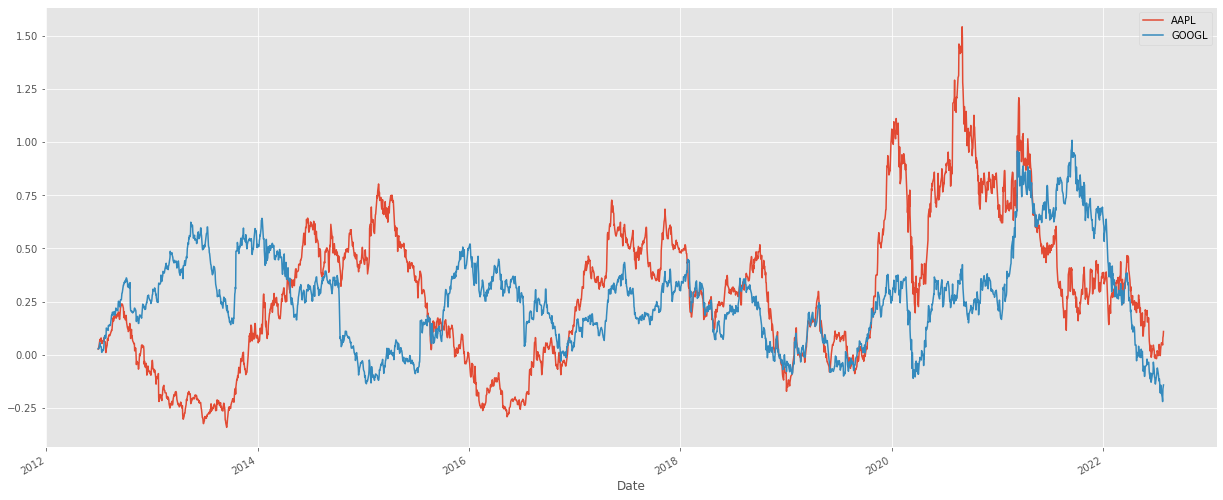

In [23]:
baseline_rolling_rets["raw_cumrets"]["daily"]["12m"][["AAPL", "GOOGL"]].plot(**plot_args);

All together (different window, same asset)

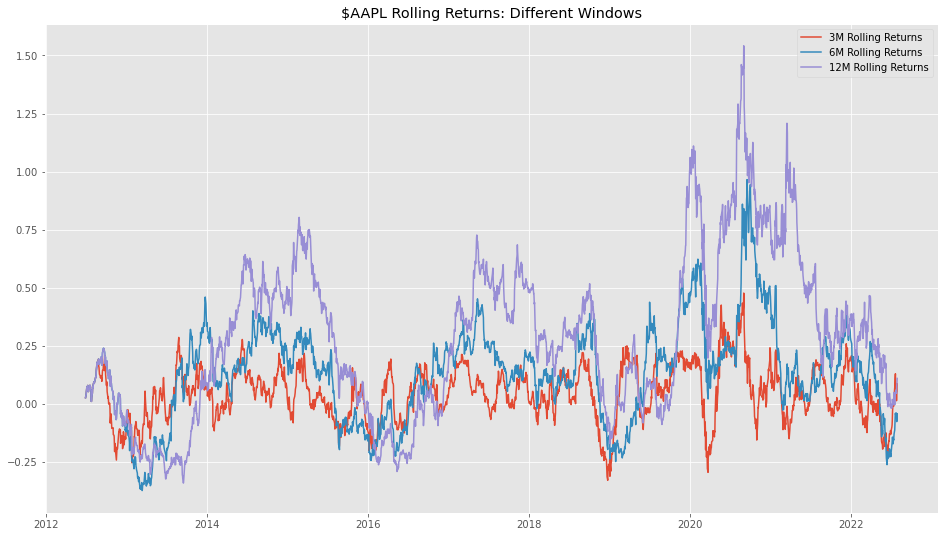

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

line3m, =ax.plot(baseline_rolling_rets["raw_cumrets"]["daily"]["3m"][["AAPL"]]);
line6m, =ax.plot(baseline_rolling_rets["raw_cumrets"]["daily"]["6m"][["AAPL"]]);
line12m, =ax.plot(baseline_rolling_rets["raw_cumrets"]["daily"]["12m"][["AAPL"]]);

line3m.set_label("3M Rolling Returns")
line6m.set_label("6M Rolling Returns")
line12m.set_label("12M Rolling Returns")
ax.set_title("$AAPL Rolling Returns: Different Windows")
ax.legend();

##### Scoring with Rolling Returns and Heuristical Trading Rules

In [25]:
# Ventile Classificatin by Default (`pd.cut(data, bins=20, labels=False`)
baseline_daily_rank_1m = baseline_rolling_rets["raw_cumrets"]["daily"]["1m"].dropna().rank(axis=1).apply(pms.scorer, axis=1)
baseline_daily_rank_3m = baseline_rolling_rets["raw_cumrets"]["daily"]["3m"].dropna().rank(axis=1).apply(pms.scorer, axis=1)
baseline_daily_rank_6m = baseline_rolling_rets["raw_cumrets"]["daily"]["6m"].dropna().rank(axis=1).apply(pms.scorer, axis=1)
baseline_daily_rank_12m = baseline_rolling_rets["raw_cumrets"]["daily"]["12m"].dropna().rank(axis=1).apply(pms.scorer, axis=1)

##### **Trading Rules**: _Daily_ Signaling

In [26]:
mk_daily_trading_1m = baseline_daily_rank_1m.shift(1)==19
mk_daily_trading_3m = baseline_daily_rank_3m.shift(1)==19
mk_daily_trading_6m = baseline_daily_rank_6m.shift(1)==19
mk_daily_trading_12m = baseline_daily_rank_12m.shift(1)==19

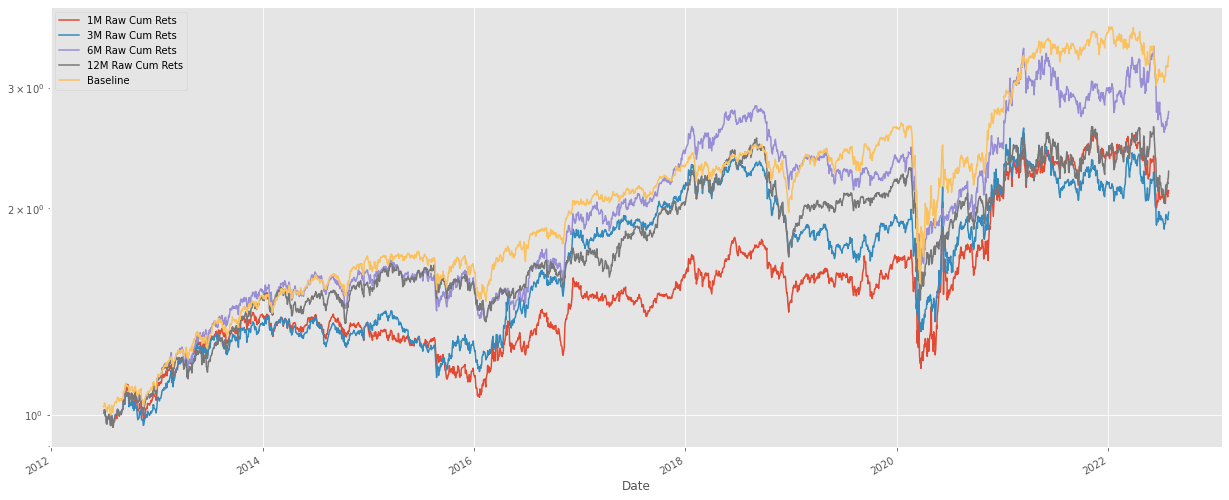

In [27]:
(1+baseline_daily_rets[mk_daily_trading_1m].mean(axis=1, skipna=True)).rename("1M Raw Cum Rets").cumprod().plot(**plot_args)
(1+baseline_daily_rets[mk_daily_trading_3m].mean(axis=1, skipna=True)).rename("3M Raw Cum Rets").cumprod().plot(**plot_args)
(1+baseline_daily_rets[mk_daily_trading_6m].mean(axis=1, skipna=True)).rename("6M Raw Cum Rets").cumprod().plot(**plot_args)
(1+baseline_daily_rets[mk_daily_trading_12m].mean(axis=1, skipna=True)).rename("12M Raw Cum Rets").cumprod().plot(**plot_args)
#NoMask (SP500 EW)
(1+baseline_daily_rets.mean(axis=1, skipna=True)).rename("Baseline").cumprod().plot(**plot_args)
plt.semilogy();

In [28]:
pd.concat(
    [
        baseline_daily_rank_12m.iloc[0].rename("rank"),
        baseline_rolling_rets["raw_cumrets"]["daily"]["6m"].iloc[0].rename("cumret")
    ],
    axis=1,
    join="inner"
).sort_values(by=["cumret"], ascending=False)

,rank,cumret
STZ,19,0.243566
FBC,19,0.105263
ANF,19,0.083809
TBI,19,0.079498
KTOS,19,0.079482
...,...,...
UNH,0,-0.018456
SBCF,0,-0.026144
HUM,0,-0.026646
F,0,-0.049554


##### __SP500-Biased Portfolio__

In [29]:
sp500b_rolling_rets = {}
sp500b_rolling_rets["raw_cumrets"] = {}
sp500b_rolling_rets["raw_cumrets"]["daily"] = {}

In [30]:
import gc
gc.collect()

7369

In [31]:
wins = ["1m", "3m", "6m", "12m"]
nperiods = [("30D", 21), ("90D", 63), ("180D", 126), ("360D", 252)]

for win, nperiod in zip(wins,nperiods):
    sp500b_rolling_rets["raw_cumrets"]["daily"][win] = sp500.rolling(
        window=nperiod[0],
    ).apply(
        pms.multi_period_return        
    )    

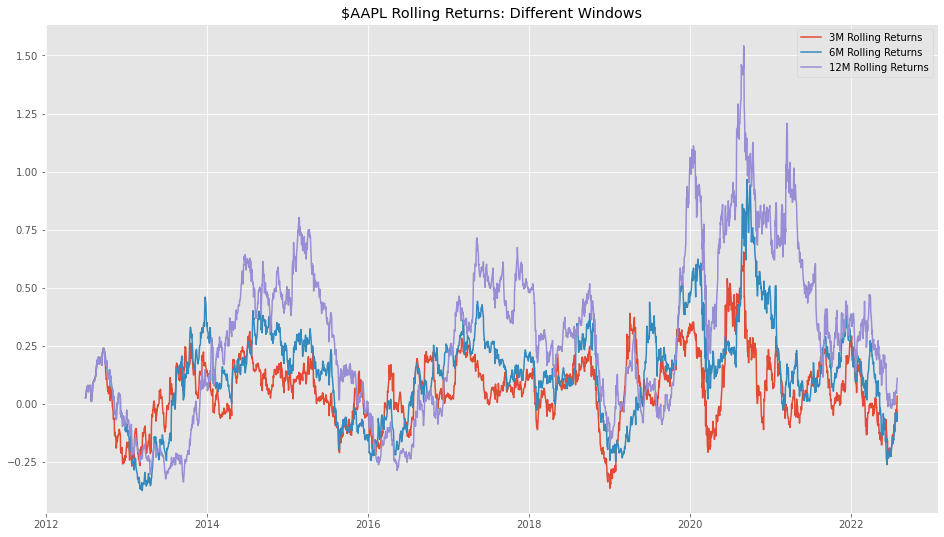

In [32]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

line3m, =ax.plot(sp500b_rolling_rets["raw_cumrets"]["daily"]["3m"][["AAPL"]]);
line6m, =ax.plot(sp500b_rolling_rets["raw_cumrets"]["daily"]["6m"][["AAPL"]]);
line12m, =ax.plot(sp500b_rolling_rets["raw_cumrets"]["daily"]["12m"][["AAPL"]]);

line3m.set_label("3M Rolling Returns")
line6m.set_label("6M Rolling Returns")
line12m.set_label("12M Rolling Returns")
ax.set_title("$AAPL Rolling Returns: Different Windows")
ax.legend();

In [33]:
sp500_rank_daily_1m = sp500b_rolling_rets["raw_cumrets"]["daily"]["1m"].dropna(subset=["AAPL"]).rank(axis=1).apply(pms.scorer, axis=1)
sp500_rank_daily_3m = sp500b_rolling_rets["raw_cumrets"]["daily"]["3m"].dropna(subset=["AAPL"]).rank(axis=1).apply(pms.scorer, axis=1)
sp500_rank_daily_6m = sp500b_rolling_rets["raw_cumrets"]["daily"]["6m"].dropna(subset=["AAPL"]).rank(axis=1).apply(pms.scorer, axis=1)
sp500_rank_daily_12m = sp500b_rolling_rets["raw_cumrets"]["daily"]["12m"].dropna(subset=["AAPL"]).rank(axis=1).apply(pms.scorer, axis=1)

In [34]:
sp500_rank_daily_1m

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,16.0,10.0,NaN,NaN,9.0,NaN,4.0,NaN,8.0,NaN,...,11.0,5.0,7.0,NaN,2.0,12.0,NaN,7.0,NaN,NaN
2012-07-02,12.0,3.0,NaN,NaN,15.0,NaN,9.0,NaN,8.0,NaN,...,11.0,5.0,5.0,NaN,1.0,12.0,NaN,12.0,NaN,NaN
2012-07-03,14.0,12.0,NaN,NaN,14.0,NaN,5.0,NaN,7.0,NaN,...,5.0,5.0,12.0,NaN,0.0,9.0,NaN,9.0,NaN,NaN
2012-07-05,14.0,14.0,NaN,NaN,18.0,NaN,5.0,NaN,8.0,NaN,...,6.0,4.0,11.0,NaN,4.0,6.0,NaN,6.0,NaN,NaN
2012-07-06,5.0,11.0,NaN,NaN,18.0,NaN,2.0,NaN,13.0,NaN,...,4.0,4.0,11.0,NaN,7.0,4.0,NaN,10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25,10.0,NaN,4.0,12.0,18.0,5.0,2.0,18.0,6.0,NaN,...,3.0,NaN,15.0,NaN,10.0,5.0,15.0,8.0,NaN,7.0
2022-07-26,13.0,NaN,3.0,7.0,17.0,7.0,4.0,18.0,7.0,NaN,...,4.0,NaN,17.0,NaN,12.0,6.0,16.0,6.0,NaN,9.0
2022-07-27,14.0,NaN,9.0,6.0,18.0,4.0,2.0,18.0,6.0,NaN,...,4.0,NaN,17.0,NaN,10.0,8.0,17.0,7.0,NaN,8.0


In [35]:
mk_daily_trading_1m=(sp500_rank_daily_1m.shift(1)==19)
mk_daily_trading_3m=(sp500_rank_daily_3m.shift(1)==19)
mk_daily_trading_6m=(sp500_rank_daily_6m.shift(1)==19)
mk_daily_trading_12m=(sp500_rank_daily_12m.shift(1)==19)

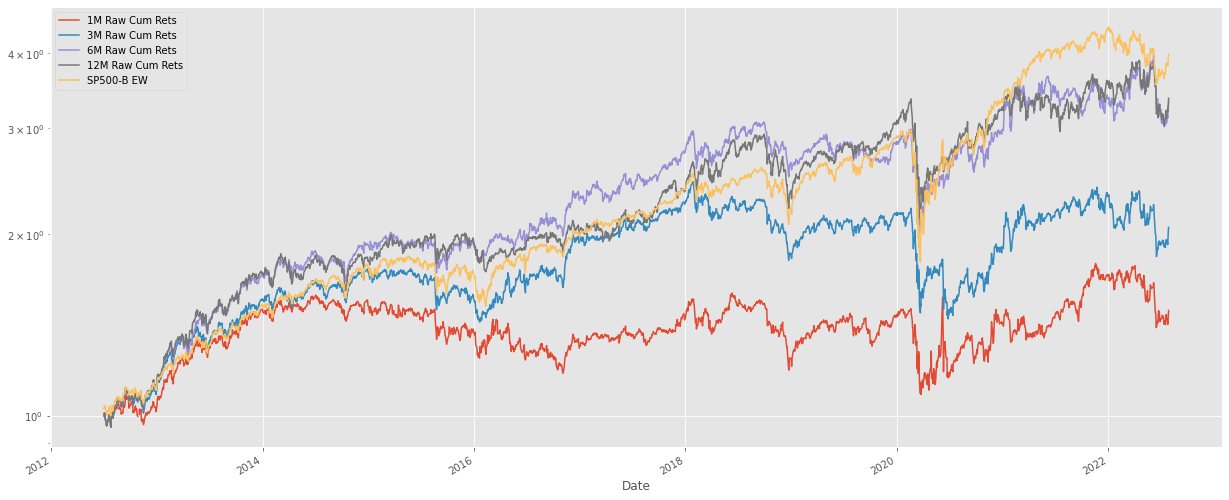

In [36]:
(1+sp500[mk_daily_trading_1m].mean(axis=1, skipna=True)).rename("1M Raw Cum Rets").cumprod().plot(**plot_args)
(1+sp500[mk_daily_trading_3m].mean(axis=1, skipna=True)).rename("3M Raw Cum Rets").cumprod().plot(**plot_args)
(1+sp500[mk_daily_trading_6m].mean(axis=1, skipna=True)).rename("6M Raw Cum Rets").cumprod().plot(**plot_args)
(1+sp500[mk_daily_trading_12m].mean(axis=1, skipna=True)).rename("12M Raw Cum Rets").cumprod().plot(**plot_args)
#NoMask (SP500 EW)
(1+sp500.mean(axis=1, skipna=True)).rename("SP500-B EW").cumprod().plot(**plot_args)
plt.semilogy();

**CONCLUSIONS**: Rolling Returns (daily calculated with several window of calculation) and daily signaling.

#### 3.3.2.2 Weekly Rolling Returns

In [37]:
baseline_rolling_rets["raw_cumrets"]["daily"].keys()

dict_keys(['1m', '3m', '6m', '12m'])

In [38]:
# Reset Sample Set
baseline_daily_rets = data["raw_returns"]["daily"]
print(baseline_daily_rets.index[0])
print(baseline_daily_rets.index[-1])

"""#Cut ICYMI
baseline_daily_rets = baseline_daily_rets[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT] """

2006-10-02 00:00:00
2022-08-31 00:00:00


'#Cut ICYMI\nbaseline_daily_rets = baseline_daily_rets[START_TRAINING_DATE_CUT:END_TRAINING_DATE_CUT] '

In [41]:
baseline_rolling_rets["raw_cumrets"]["weekly"] = {}

In [55]:
wins = ["1m", "2m", "3m", "6m", "12m"]
ndays = [21, 42, 63, 126, 252]

for win_label, window in zip(wins,ndays):
    print(f"{win_label} : {window} daily periods")
    baseline_rolling_rets["raw_cumrets"]["weekly"][win_label] = \
        baseline_daily_rets.rolling(window=window).apply(
            pms.multi_period_return,
            engine="numba",
            raw=True
        )
    
    baseline_rolling_rets["raw_cumrets"]["weekly"][win_label] = \
        baseline_rolling_rets["raw_cumrets"]["weekly"][win_label].resample("W-FRI").apply(
            lambda x: x[-1]
        )

1m : 21 daily periods
2m : 42 daily periods
3m : 63 daily periods
6m : 126 daily periods
12m : 252 daily periods


In [56]:
baseline_rolling_rets["raw_cumrets"]["weekly"].keys()

dict_keys(['1m', '2m', '3m', '6m', '12m'])

In [57]:
baseline_weekly_rets = data["raw_returns"]["weekly"]

In [58]:
mk_weekly_high_scored.sum().sort_values(ascending=False).head(25)

NVDA    255
AMD     243
AMZN    205
MU      203
WW      168
MGI     168
AAPL    164
ANF     163
RAD     163
STRA    161
EA      155
AA      153
NKTR    150
UIS     143
CDE     137
FCX     136
KTOS    136
VLO     133
ODP     132
RCII    129
MRO     128
CYH     128
AEO     126
NEM     123
TSN     123
dtype: int64

<AxesSubplot:xlabel='Date'>

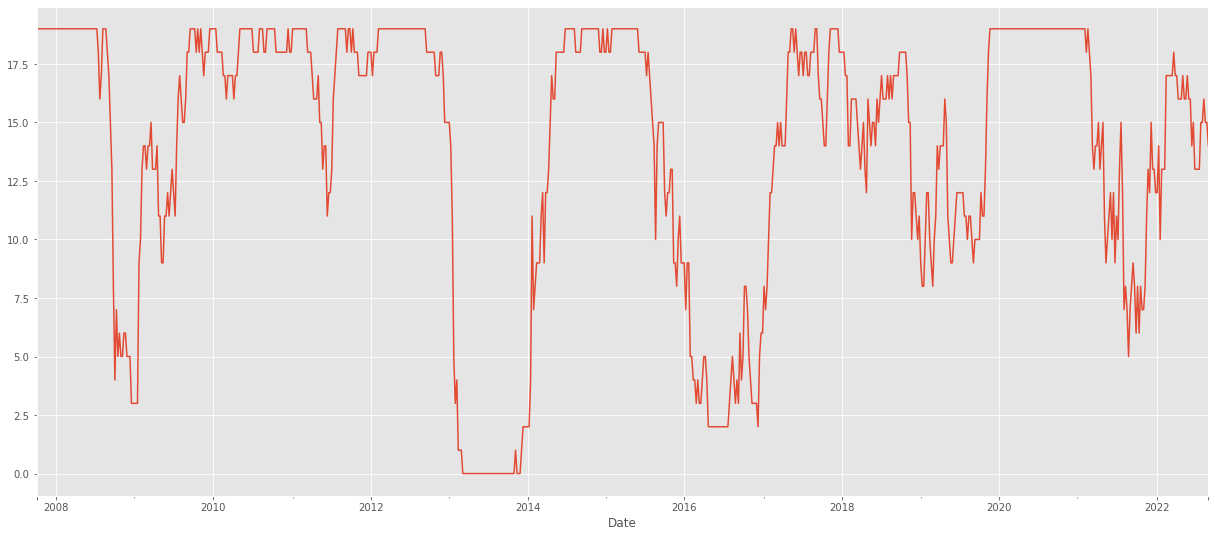

In [82]:
baseline_rolling_rets["raw_cumrets"]["weekly"]["12m"].dropna().rank(axis=1).apply(pms.scorer, axis=1)["AAPL"].plot(figsize=(21,9))

In [84]:
mk_weekly_high_scored = (baseline_rolling_rets["raw_cumrets"]["weekly"]["1m"].dropna().rank(axis=1).apply(pms.scorer, bins=10, axis=1).shift(1)==9)
#mk_weekly_low_scored = (baseline_rolling_rets["raw_cumrets"]["weekly"]["26w"].dropna().rank(axis=1).apply(pms.scorer, axis=1).shift(1)==0)

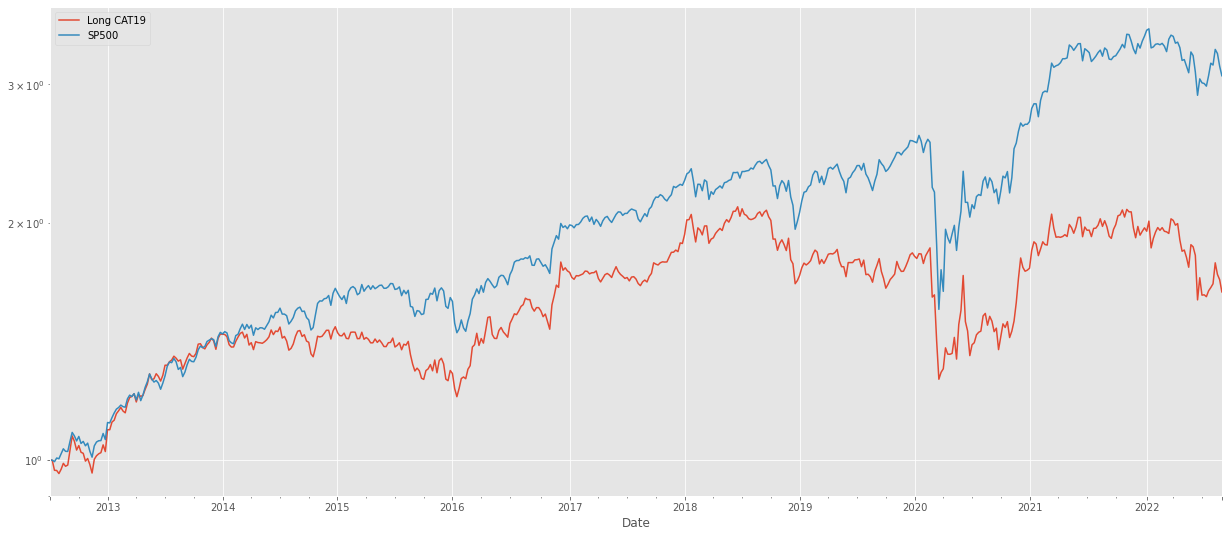

In [85]:
(1+baseline_weekly_rets[mk_weekly_high_scored]["2012-07-01":].mean(axis=1,skipna=True)).rename("Long CAT19").cumprod().plot(**plot_args)
#(1+baseline_weekly_rets[mk_weekly_low_scored].mean(axis=1,skipna=True)).rename("Long CAT0").cumprod().plot(**plot_args)
(1+baseline_weekly_rets["2012-07-01":].mean(axis=1,skipna=True)).rename("SP500").cumprod().plot(**plot_args);

plt.semilogy();

#### 3.3.2.3 Monthly Rolling Returns

Resampling **predictor** to the end of each month

In [86]:
data.keys()

dict_keys(['raw_returns', 'sma_vols', 'ewma_vols', 'score'])

In [87]:
data["raw_returns"].keys()

dict_keys(['daily', 'weekly', 'monthly'])

In [88]:
baseline_monthly_returns = data["raw_returns"]["monthly"]

In [89]:
baseline_rolling_rets["raw_cumrets"].keys()

dict_keys(['daily', 'weekly'])

In [90]:
baseline_rolling_rets["raw_cumrets"]["monthly"] = {}

In [91]:
wins = ["1m", "2m", "3m", "6m", "12m"]
ndays = [21, 42, 63, 126, 252]

for win_label, window in zip(wins,ndays):
    print(f"{win_label} : {window} daily periods")
    baseline_rolling_rets["raw_cumrets"]["monthly"][win_label] = \
        baseline_daily_rets.rolling(window=window).apply(
            pms.multi_period_return,
            engine="numba",
            raw=True
        ).resample("BM").apply(
            lambda x: x[-1]
        )

1m : 21 daily periods
2m : 42 daily periods
3m : 63 daily periods
6m : 126 daily periods
12m : 252 daily periods


<AxesSubplot:xlabel='Date'>

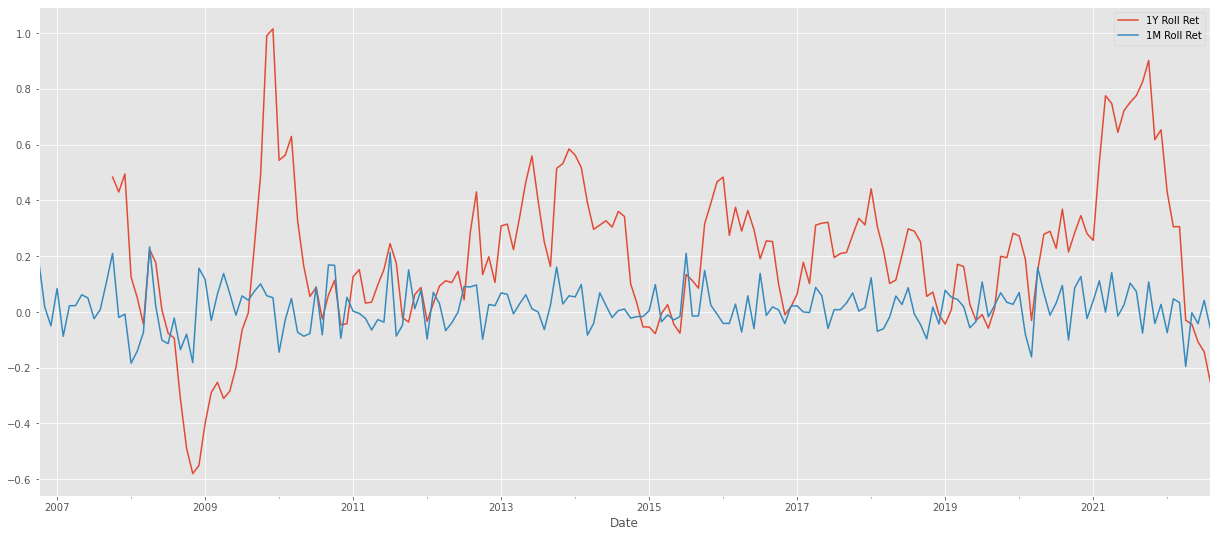

In [92]:
baseline_rolling_rets["raw_cumrets"]["monthly"]["12m"]["GOOGL"].rename("1Y Roll Ret").plot(figsize=(21,9), legend=True)
baseline_rolling_rets["raw_cumrets"]["monthly"]["1m"]["GOOGL"].rename("1M Roll Ret").plot(legend=True)

In [163]:
rolling_rets_weekly = baseline_rolling_rets["raw_cumrets"]["weekly"]["1m"]
rolling_rets_weekly.dropna(how="all", inplace=True)
rolling_rets_weekly = rolling_rets_weekly[:rolling_rets_weekly.index[-2]]
rolling_rets_weekly

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-03,0.062292,0.046238,-0.028033,0.034387,-0.011262,0.057588,-0.084759,0.006080,0.024175,0.019515,...,-0.021205,-0.029293,-0.020629,-0.110534,-0.008802,0.081324,0.021739,0.089205,0.039130,-0.042522
2006-11-10,0.085345,0.104438,-0.022525,-0.010334,0.031405,0.061116,-0.034313,0.037969,-0.017285,0.020292,...,0.014578,-0.033714,-0.003793,-0.114147,-0.014870,0.090105,0.005183,0.043667,0.022727,-0.029269
2006-11-17,0.025764,0.086846,0.011184,-0.005217,0.076903,0.136348,-0.090877,0.047911,0.160893,-0.006096,...,-0.007174,-0.049036,0.037670,-0.151536,-0.007496,0.083634,0.010305,0.008210,0.017261,0.009380
2006-11-24,0.016787,0.121817,-0.026490,-0.027548,0.066769,0.070076,-0.133416,0.036960,0.127746,-0.023403,...,-0.021281,-0.059483,-0.002359,-0.056639,-0.029935,0.069794,-0.003857,-0.011578,0.081829,0.015477
2006-12-01,-0.062188,0.153613,-0.028877,-0.017925,0.042108,0.034909,-0.045968,-0.018051,0.133756,0.009210,...,0.003179,-0.035248,0.009999,-0.076923,-0.007872,0.041918,0.014751,-0.096587,0.065012,0.009438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-29,0.139419,0.167205,0.016367,0.002051,0.112944,0.167651,0.071595,0.136340,0.223183,0.038822,...,0.022893,0.021967,0.103909,0.083586,0.049813,0.108087,0.127892,-0.006836,0.089549,0.066844
2022-08-05,0.084937,0.131395,0.003693,0.002243,0.108829,0.193040,0.112366,0.141696,0.216461,0.034678,...,0.006108,0.038666,-0.004751,0.109266,0.045454,0.018307,0.131250,-0.100021,0.085617,0.071794
2022-08-12,0.152485,0.160767,0.081979,0.054583,0.194954,0.169265,0.207810,0.215814,0.362950,0.089374,...,-0.001825,0.028747,0.095214,0.119403,0.101929,0.043587,0.143791,-0.006189,0.175579,0.113891


##### An Excerpt: Relations Past (Cumulative) Returns between Realized Return Over The Next Period (Weak)

In [173]:
# Melting and Aligning Features with the Return
baseline_weekly_returns = data["raw_returns"]["weekly"]
baseline_weekly_returns = baseline_weekly_returns.shift(-1)[rolling_rets_weekly.index[0]:rolling_rets_weekly.index[-1]]

In [174]:
X_poc = pd.melt(
    rolling_rets_weekly,
    var_name="symbols",
    value_name="past_return",
    ignore_index=False
).dropna()

In [175]:
y_poc = pd.melt(
    baseline_weekly_returns,
    var_name="symbols",
    value_name="next_month_return",
    ignore_index=False
).dropna()

In [176]:
X_poc

,symbols,past_return
Date,,
2006-11-03,A,0.062292
2006-11-10,A,0.085345
2006-11-17,A,0.025764
2006-11-24,A,0.016787
2006-12-01,A,-0.062188
...,...,...
2022-07-29,WABC,0.066844
2022-08-05,WABC,0.071794
2022-08-12,WABC,0.113891


In [177]:
y_poc

,symbols,next_month_return
Date,,
2006-11-03,A,0.042818
2006-11-10,A,-0.017181
2006-11-17,A,-0.005630
2006-11-24,A,-0.047378
2006-12-01,A,0.045668
...,...,...
2022-07-29,WABC,-0.008934
2022-08-05,WABC,0.016427
2022-08-12,WABC,0.002832


In [178]:
filterX_ = X_poc["symbols"] == "AAPL"
filtery_ = y_poc["symbols"] == "AAPL"

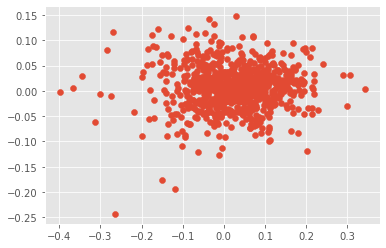

In [179]:
plt.scatter(X_poc[filterX_].iloc[:,-1], y_poc[filtery_].iloc[:,-1],) # Particularizing to $AAPL

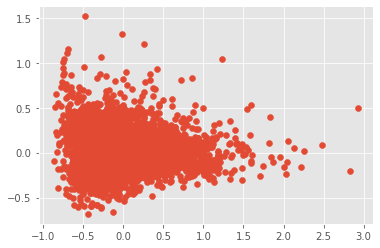

In [180]:
plt.scatter(X_poc.iloc[:,-1], y_poc.iloc[:,-1],)

In [93]:
NCATS = 20
colors = plt.cm.rainbow(np.linspace(0, 1, NCATS))

In [182]:
baseline_monthly_returns = data["raw_returns"]["monthly"]
baseline_monthly_returns

,A,AAPL,ABC,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,NWN,PRGO,RGP,SBCF,SHBI,UGI,WAFD,FORR,FRT,WABC
Date,,,,,,,,,,,,,,,,,,,,,
2006-10-31,0.101485,0.083089,0.043786,-0.008851,0.033784,0.085266,0.011826,0.051021,0.096360,0.024427,...,0.063013,0.059834,0.065146,-0.083851,0.068867,0.083402,0.046690,0.160207,0.090922,-0.001202
2006-11-30,-0.050771,0.130488,-0.024598,-0.017891,0.049935,0.026872,-0.085770,-0.024474,0.120544,0.011276,...,-0.003142,-0.059611,0.003110,-0.096045,-0.025785,0.063396,-0.000430,-0.105313,0.062758,0.000512
2006-12-29,0.094535,-0.074406,-0.022396,0.043935,0.023904,0.010762,-0.089459,0.026060,-0.017484,-0.006397,...,0.029098,0.030989,0.096796,0.040222,0.043959,-0.025794,0.021730,-0.035917,0.004777,0.022209
2007-01-31,-0.081779,0.010491,0.165036,0.094464,-0.054718,-0.003650,0.001251,-0.031066,0.080573,-0.011539,...,-0.032817,-0.001156,-0.013819,-0.068145,-0.049735,0.004765,-0.014450,0.038731,0.099059,-0.017184
2007-02-28,-0.007812,-0.013064,0.005116,0.030565,0.009776,0.108703,0.076981,0.042539,-0.058783,-0.017134,...,0.087982,-0.031059,0.030573,0.026828,-0.081880,-0.047428,0.025442,-0.047230,-0.031364,-0.006475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29,-0.097278,-0.097131,-0.022106,-0.037239,-0.130964,-0.065383,-0.007755,-0.041136,-0.116958,-0.009172,...,-0.066038,-0.107468,0.002917,-0.071959,-0.017090,-0.053009,-0.072821,-0.012939,-0.041042,-0.026116
2022-05-31,0.069506,-0.054496,0.026248,0.034890,0.051850,0.095893,0.018743,0.021817,0.097580,0.024650,...,0.135062,0.162099,0.083529,0.053539,0.011206,0.246064,0.074561,-0.060334,-0.017854,0.029261
2022-06-30,-0.068909,-0.081430,-0.085987,-0.075004,-0.121062,-0.132482,-0.145563,-0.053388,-0.172274,-0.044690,...,-0.021919,0.024468,0.102870,-0.029804,-0.085516,-0.088537,-0.074884,-0.085802,-0.157746,-0.075569


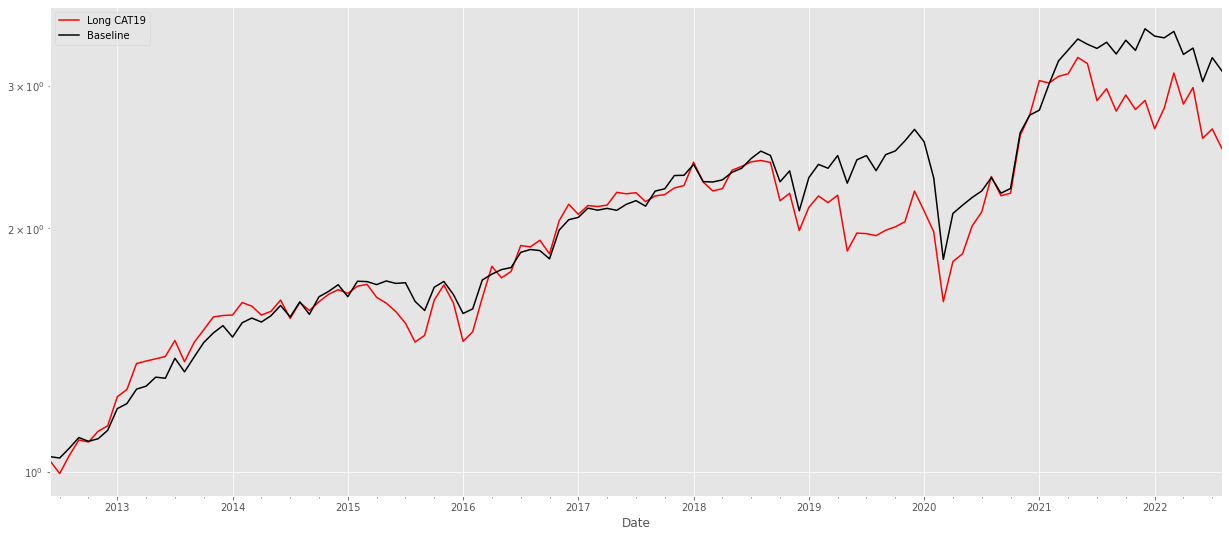

In [236]:
# Plotting Ventile-based Portfolios Against the Portfolio proxyfying the Index $RSP (in Black)
for bin in range(0,NCATS):    
    if bin==NCATS-1:
        mask180 = (
            baseline_rolling_rets["raw_cumrets"]["monthly"]["2m"].dropna().rank(axis=1).apply(
            pms.scorer, 
            bins=NCATS, 
            axis=1).shift(1)==bin
        )
        (1+baseline_monthly_returns[mask180][START_TRAINING_DATE_CUT:].mean(axis=1,skipna=True)).rename("Long CAT" +str(bin)).cumprod().plot(**plot_args, color=colors[bin])

(1+baseline_monthly_returns[START_TRAINING_DATE_CUT:].mean(axis=1,skipna=True)).rename("Baseline").cumprod().plot(**plot_args, color="black")

plt.semilogy();

In [221]:
X_poc.isna().sum()

symbols        0
past_return    0
dtype: int64

In [223]:
y_poc.shape

(387394, 2)

### **First Conclusions:**

1. Portfolios constructed from ranked stocks could outperform the proxy portofolio build from S&P500 components.

2. _Rolling Returns 30D to 90D **sampled monthly**_ are good candidates for predictors (features). It is less clear for _360D_ (1Y) _Rolling Returns_ even though it is interesting to include as a feature as well.

3. **Daily Rebalancing** have to be avoided because of operational problems and transactional costs. On the other hand, portfolio selection/construction based on rankers provide less conclusive impact on wealth at the end of the data period which will be used for training machine learning models.

4. Cumulative Returns are sensible to portfolio sizes. We start the modelling by fixing signaling (trading rules provided by the LTR models) to construct ventile-sized portfolios

5. Some kind of correlation analysis between features can be instructive (dimensionality reduction)

#### Exports for Later Use

Let us export features sampled monthly for later use. A systematic approach to slicing (a python script with the constant dates defining the maximum sample considered is on the way)

In [241]:
%whos dict

Variable                Type    Data/Info
-----------------------------------------
baseline_rolling_rets   dict    n=1
data                    dict    n=4
plot_args               dict    n=2
sp500b_rolling_rets     dict    n=1


In [242]:
baseline_rolling_rets.keys()

dict_keys(['raw_cumrets'])

In [243]:
#print(baseline_rolling_rets["raw_cumrets"]["daily"]["12m"].shape)
print(baseline_rolling_rets["raw_cumrets"]["monthly"]["12m"].shape)
print(baseline_rolling_rets["raw_cumrets"]["weekly"]["12m"].shape)

(179, 469)
(831, 469)


*  Dumping Rolling Past Cumulative Returns

In [246]:
with open("data/config/20220831_raw_rolling_rets_data.pkl","wb") as file:
    pickle.dump(baseline_rolling_rets, file, protocol=pickle.HIGHEST_PROTOCOL)